<a href="https://colab.research.google.com/github/carpalmar/IA-FUNDAMENTALS/blob/main/PC3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Callable
import time
from dataclasses import dataclass
import seaborn as sns
from tqdm import tqdm

In [5]:
@dataclass
class GeneticConfig:
    num_cities: int = 100
    pop_size: int = 100
    num_generations: int = 200
    mutation_rate: float = 0.1
    crossover_rate: float = 0.9
    tournament_size: int = 5
    elite_size: int = 2

class TSPSolver:
    def __init__(self, config: GeneticConfig):
        self.config = config
        self.cities = None
        self.distance_matrix = None
        self.best_solution_history = []
        self.avg_fitness_history = []

    def set_cities(self, seed: int = 42):
        """Genera un conjunto fijo de ciudades usando una semilla"""
        np.random.seed(seed)
        self.cities = np.random.rand(self.config.num_cities, 2)
        self.distance_matrix = self.calculate_distance_matrix()
        np.random.seed()  # Resetear la semilla para futuras operaciones aleatorias

    def calculate_distance_matrix(self) -> np.ndarray:
        """Calcula matriz de distancias usando broadcasting"""
        diff = self.cities[:, np.newaxis] - self.cities
        return np.sqrt(np.sum(diff * diff, axis=2))

    def fitness(self, solution: List[int]) -> float:
        """Calcula el fitness (distancia total de la ruta)"""
        route = solution + [solution[0]]  # Cerrar el ciclo
        return np.sum(self.distance_matrix[route[:-1], route[1:]])

    # Métodos de inicialización
    def random_initialization(self) -> List[List[int]]:
        """Inicialización aleatoria de la población"""
        return [np.random.permutation(self.config.num_cities).tolist()
                for _ in range(self.config.pop_size)]

    def heuristic_initialization(self) -> List[List[int]]:
        """Inicialización heurística usando vecino más cercano"""
        population = []
        for _ in range(self.config.pop_size):
            current = np.random.randint(self.config.num_cities)
            unvisited = set(range(self.config.num_cities)) - {current}
            route = [current]

            while unvisited:
                next_city = min(unvisited,
                              key=lambda x: self.distance_matrix[current][x])
                route.append(next_city)
                unvisited.remove(next_city)
                current = next_city

            population.append(route)
        return population

    def hybrid_initialization(self) -> List[List[int]]:
        """Inicialización híbrida (50% aleatoria, 50% heurística)"""
        random_part = self.random_initialization()[:self.config.pop_size//2]
        heuristic_part = self.heuristic_initialization()[:self.config.pop_size//2]
        return random_part + heuristic_part

    # Métodos de selección
    def roulette_wheel_selection(self, population: List[List[int]],
                               fitnesses: List[float]) -> List[int]:
        """Selección por ruleta"""
        total_fitness = sum(fitnesses)
        # Convertir problema de minimización a maximización
        modified_fitnesses = [total_fitness - f for f in fitnesses]
        total_modified = sum(modified_fitnesses)
        r = np.random.random() * total_modified
        current_sum = 0
        for ind, fit in zip(population, modified_fitnesses):
            current_sum += fit
            if current_sum > r:
                return ind.copy()
        return population[-1].copy()

    def rank_based_selection(self, population: List[List[int]],
                           fitnesses: List[float]) -> List[int]:
        """Selección basada en ranking"""
        sorted_indices = np.argsort(fitnesses)
        ranks = np.arange(len(population))
        probs = ranks / ranks.sum()
        chosen_idx = np.random.choice(len(population), p=probs)
        return population[sorted_indices[chosen_idx]].copy()

    def fitness_scaling_selection(self, population: List[List[int]],
                                fitnesses: List[float]) -> List[int]:
        """Selección por escalado de fitness"""
        min_fit = min(fitnesses)
        max_fit = max(fitnesses)
        if max_fit == min_fit:
            scaled = [1 for _ in fitnesses]
        else:
            scaled = [(max_fit - f)/(max_fit - min_fit) for f in fitnesses]
        total = sum(scaled)
        probs = [s/total for s in scaled]
        return population[np.random.choice(len(population), p=probs)].copy()

    def tournament_selection(self, population: List[List[int]],
                           fitnesses: List[float]) -> List[int]:
        """Selección por torneo"""
        tournament = np.random.choice(len(population),
                                    size=self.config.tournament_size,
                                    replace=False)
        tournament_fitnesses = [fitnesses[i] for i in tournament]
        winner = tournament[np.argmin(tournament_fitnesses)]
        return population[winner].copy()

    def ordered_crossover(self, parent1: List[int], parent2: List[int]) -> List[int]:
        """Operador de cruce ordenado (OX)"""
        size = len(parent1)
        start, end = sorted(np.random.choice(size, 2, replace=False))
        child = [-1] * size
        child[start:end] = parent1[start:end]
        remaining = [x for x in parent2 if x not in child[start:end]]
        j = 0
        for i in range(size):
            if child[i] == -1:
                child[i] = remaining[j]
                j += 1
        return child

    def swap_mutation(self, solution: List[int]) -> None:
        """Operador de mutación por intercambio"""
        if np.random.random() < self.config.mutation_rate:
            i, j = np.random.choice(len(solution), 2, replace=False)
            solution[i], solution[j] = solution[j], solution[i]

    def evolve(self, selection_method: str, init_method: str) -> Tuple[List[int], float, List[float]]:
        """Proceso evolutivo principal"""
        # Diccionario de métodos de inicialización
        init_methods = {
            'random': self.random_initialization,
            'heuristic': self.heuristic_initialization,
            'hybrid': self.hybrid_initialization
        }

        # Diccionario de métodos de selección
        selection_methods = {
            'roulette': self.roulette_wheel_selection,
            'rank': self.rank_based_selection,
            'scaling': self.fitness_scaling_selection,
            'tournament': self.tournament_selection
        }

        # Inicializar población
        population = init_methods[init_method]()

        # Resetear historiales
        self.best_solution_history = []
        self.avg_fitness_history = []
        best_solution = None
        best_fitness = float('inf')

        # Evolución generacional
        for _ in range(self.config.num_generations):
            # Evaluar población actual
            fitnesses = [self.fitness(ind) for ind in population]

            # Actualizar mejor solución
            current_best = min(fitnesses)
            if current_best < best_fitness:
                best_fitness = current_best
                best_solution = population[fitnesses.index(current_best)].copy()

            # Guardar estadísticas
            self.best_solution_history.append(best_fitness)
            self.avg_fitness_history.append(np.mean(fitnesses))

            # Crear nueva población
            new_population = []

            # Elitismo
            elite_indices = np.argsort(fitnesses)[:self.config.elite_size]
            new_population.extend([population[i].copy() for i in elite_indices])

            # Generar resto de la población
            selection_func = selection_methods[selection_method]
            while len(new_population) < self.config.pop_size:
                parent1 = selection_func(population, fitnesses)
                parent2 = selection_func(population, fitnesses)

                if np.random.random() < self.config.crossover_rate:
                    child = self.ordered_crossover(parent1, parent2)
                else:
                    child = parent1.copy()

                self.swap_mutation(child)
                new_population.append(child)

            population = new_population

        return best_solution, best_fitness, self.best_solution_history

    def plot_convergence(self, method_results: dict, experiment_type: str):
        """Visualiza la convergencia de diferentes métodos"""
        plt.figure(figsize=(12, 6))
        for method, history in method_results.items():
            plt.plot(history, label=method)

        plt.title(f'Convergencia por {experiment_type}')
        plt.xlabel('Generación')
        plt.ylabel('Mejor Fitness (Distancia)')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_route(self, solution: List[int], method: str):
        """Visualiza la ruta óptima encontrada"""
        plt.figure(figsize=(8, 8))

        # Plotear ciudades
        plt.scatter(self.cities[:, 0], self.cities[:, 1],
                   c='red', s=50, label='Ciudades')

        # Plotear ruta
        route = np.array([self.cities[i] for i in solution + [solution[0]]])
        plt.plot(route[:, 0], route[:, 1], 'b-',
                label=f'Ruta ({method})', alpha=0.7)

        plt.title(f'Ruta Óptima - Método: {method}')
        plt.legend()
        plt.grid(True)
        plt.show()



Experimento 1: Comparación de métodos de selección

Ejecutando método de selección: Ruleta
Fitness final: 35.53
Tiempo de ejecución: 6.67 segundos


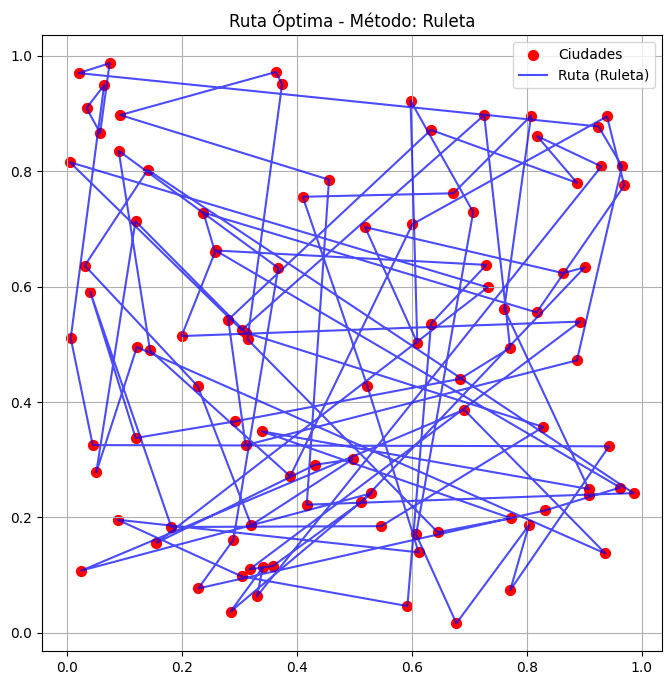


Ejecutando método de selección: Ranking
Fitness final: 47.45
Tiempo de ejecución: 4.66 segundos


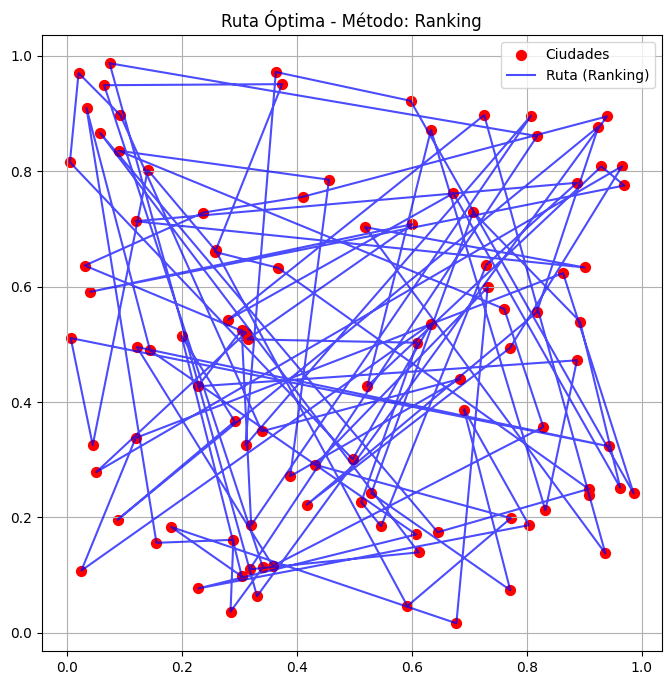


Ejecutando método de selección: Escalado
Fitness final: 22.02
Tiempo de ejecución: 7.67 segundos


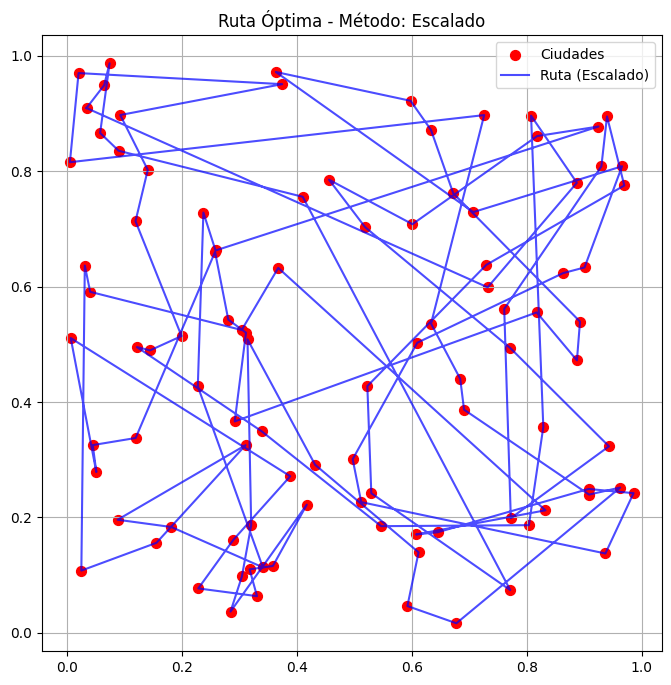


Ejecutando método de selección: Torneo
Fitness final: 18.68
Tiempo de ejecución: 3.55 segundos


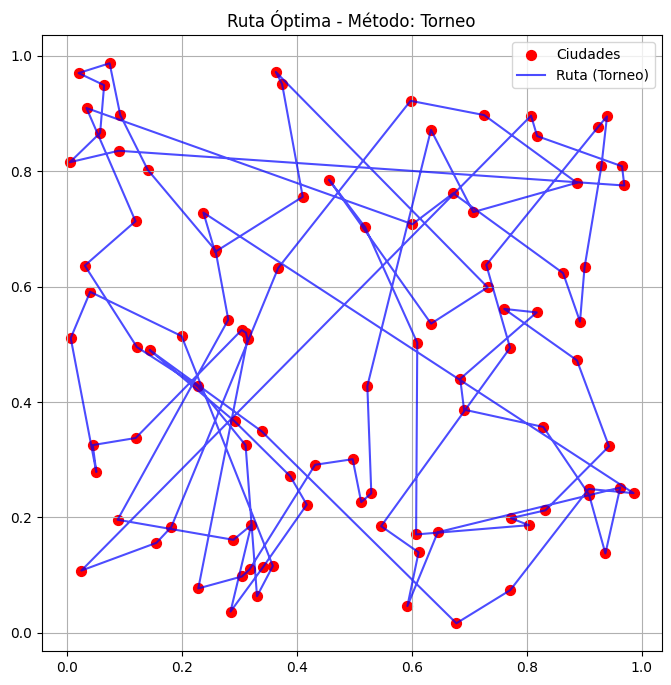

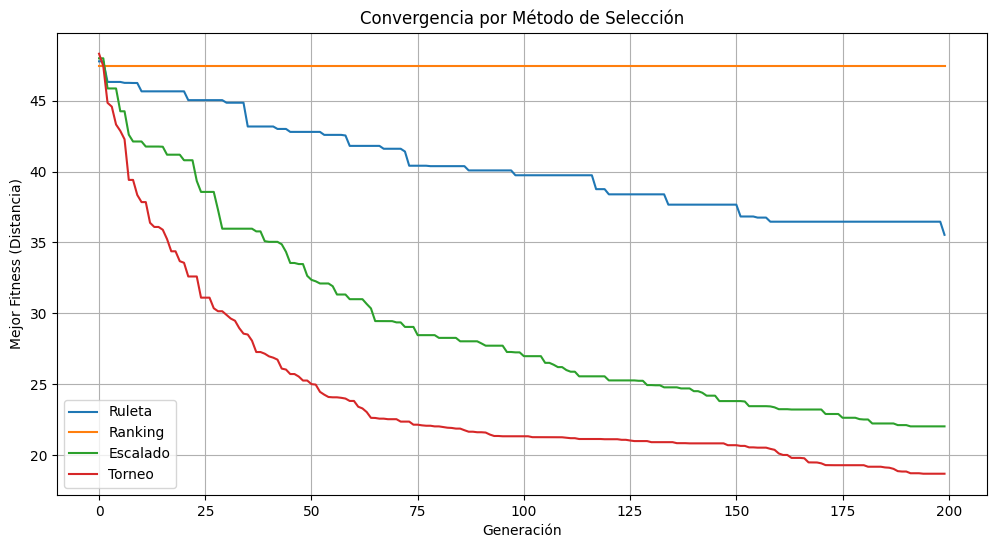


Experimento 2: Comparación de métodos de inicialización

Ejecutando método de inicialización: Aleatorio
Fitness final: 20.78
Tiempo de ejecución: 4.64 segundos


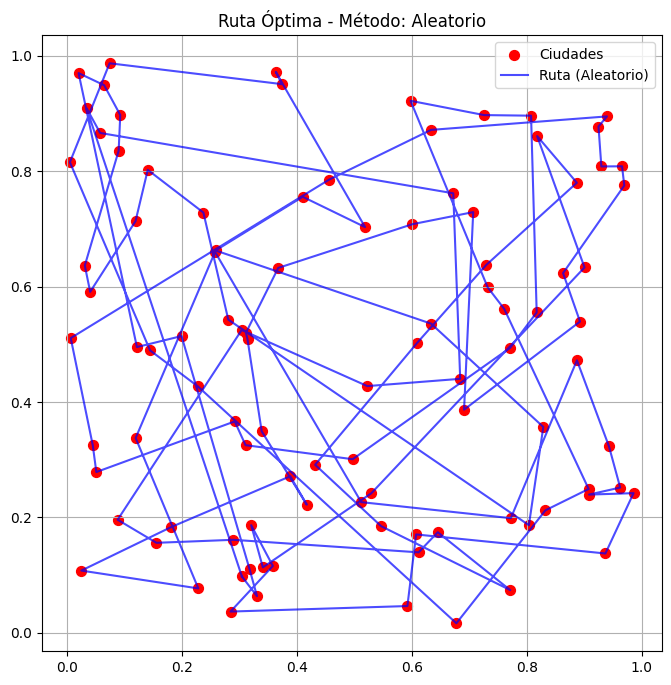


Ejecutando método de inicialización: Heurístico
Fitness final: 8.56
Tiempo de ejecución: 4.18 segundos


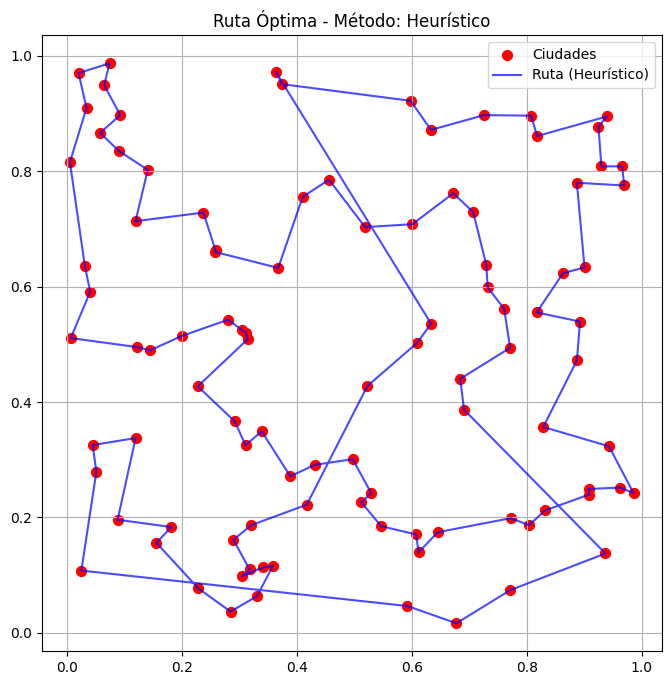


Ejecutando método de inicialización: Híbrido
Fitness final: 8.68
Tiempo de ejecución: 4.00 segundos


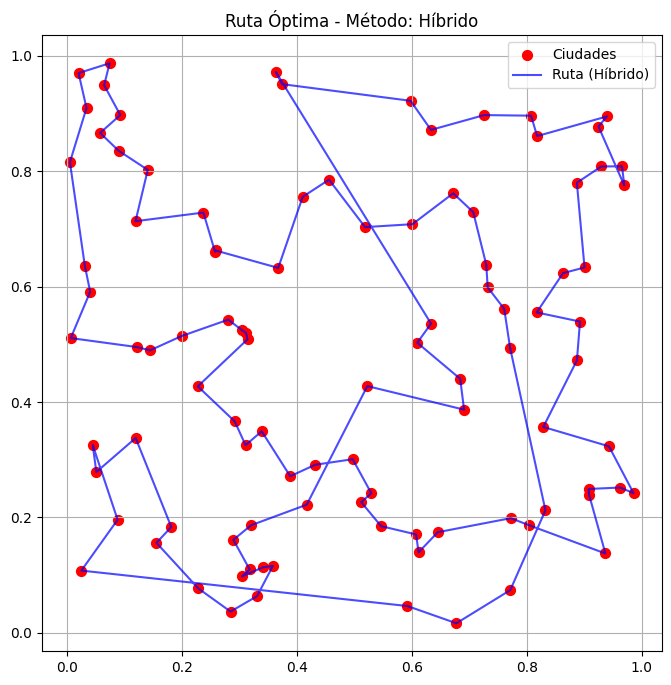

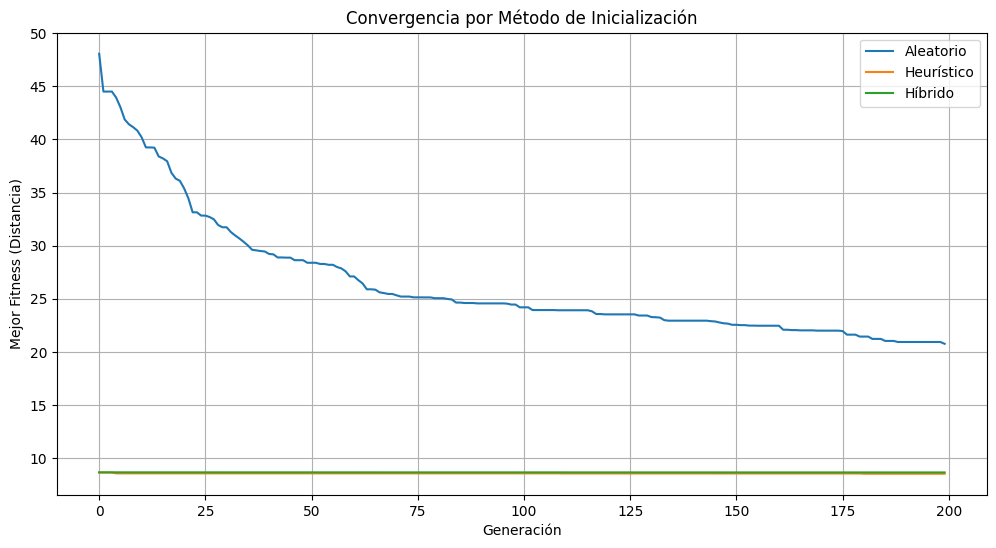

In [6]:
def run_experiments():
    """Ejecuta los dos experimentos solicitados"""
    config = GeneticConfig()
    solver = TSPSolver(config)
    solver.set_cities(seed=42)  # Usar mismo conjunto de ciudades para ambos experimentos

    # Experimento 1: Comparación de métodos de selección
    selection_methods = {
        'roulette': 'Ruleta',
        'rank': 'Ranking',
        'scaling': 'Escalado',
        'tournament': 'Torneo'
    }

    print("\nExperimento 1: Comparación de métodos de selección")
    selection_results = {}
    selection_histories = {}

    for method, name in selection_methods.items():
        print(f"\nEjecutando método de selección: {name}")
        start_time = time.time()
        solution, fitness, history = solver.evolve(method, 'random')
        end_time = time.time()

        selection_results[name] = {
            'fitness': fitness,
            'time': end_time - start_time,
            'solution': solution
        }
        selection_histories[name] = history

        print(f"Fitness final: {fitness:.2f}")
        print(f"Tiempo de ejecución: {end_time - start_time:.2f} segundos")
        solver.plot_route(solution, name)

    solver.plot_convergence(selection_histories, "Método de Selección")

    # Experimento 2: Comparación de métodos de inicialización
    init_methods = {
        'random': 'Aleatorio',
        'heuristic': 'Heurístico',
        'hybrid': 'Híbrido'
    }

    print("\nExperimento 2: Comparación de métodos de inicialización")
    init_results = {}
    init_histories = {}

    for method, name in init_methods.items():
        print(f"\nEjecutando método de inicialización: {name}")
        start_time = time.time()
        solution, fitness, history = solver.evolve('tournament', method)
        end_time = time.time()

        init_results[name] = {
            'fitness': fitness,
            'time': end_time - start_time,
            'solution': solution
        }
        init_histories[name] = history

        print(f"Fitness final: {fitness:.2f}")
        print(f"Tiempo de ejecución: {end_time - start_time:.2f} segundos")
        solver.plot_route(solution, name)

    solver.plot_convergence(init_histories, "Método de Inicialización")

    return selection_results, init_results

if __name__ == "__main__":
    selection_results, init_results = run_experiments()